# R-SHAP Implementation

### Workspace Prep

In [2]:
# import lstm_model as lm
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import shap
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger as TensorBoardLogger
import tensorboard
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.autograd import Variable 
import tqdm as notebook_tqdm

C:\Users\alexander\anaconda3\envs\itcs-8156\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Uncomment below to install missing modules### Workspace Prep

In [3]:
# pip install tensorboard

In [4]:
# pip install --ignore-installed PyYAML  # might be necessary to run before installing pytorch

In [5]:
# pip install pytorch-lightning

In [6]:
# pip install torch

### Load Pre-processing Utilities

In [9]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
# sys.path.insert(1, r'D:\Documents\GitHub\itcs-8156\utils')
sys.path.insert(1, r'H:\My Drive\SP23\ML\envs\groupWork\utils')


from preprocessing import (market_prepro,
                           lstm_timeseries_feat_and_targ,
                           
)

### Load and Pre-processs Stock Data

In [10]:
class BasicLSTM(pl.LightningModule):

    def __init__(self, num_feat, num_hiddens, num_out, lr):
        '''
        num_feat - number of features input into the model
        '''
        super().__init__()
        self.num_feat = num_feat
        self.num_hiddens = num_hiddens
        self.num_out = num_out

        self.lr = lr

        shape_w1 = (num_hiddens,num_feat)
        shape_w2 = (num_hiddens,num_hiddens)
        
        mean = 0.0
        std = 1.0

        #the forget gate weights and bias 
        #(for f_t = sig(wf1 x_t + wf2 h_{t-1} + b_f))
        self.wf1 ,self.wf2, self.bf = self.initWeights(shape_w1, shape_w2, mean, std)

        #the input gate weights and bias
        #(for i_t = sig(wi1 x_t + wi2 h_{t-1} + b_i))
        self.wi1, self.wi2, self.bi = self.initWeights(shape_w1, shape_w2, mean, std) 
        #the output gate weights and bias
        #(for o_t = sig(wo1 x_t + wo2 h_{t-1} + b_o))
        self.wo1, self.wo2, self.bo = self.initWeights(shape_w1, shape_w2, mean, std)
        #the candidate context weights and bias
        #(for c^'_t = sig(wcc1 x_t + wcc2 h_{t-1} + bc_c))
        self.wcc1, self.wcc2, self.bcc = self.initWeights(shape_w1, shape_w2, mean, std)

        self.whq = nn.Parameter(torch.normal(mean=mean,
                                             std=std,
                                             size=(num_hiddens, num_out)),
                                requires_grad=True,
                                )
        self.bq = nn.Parameter(torch.tensor(0.0),
                        requires_grad=True,
                        )

        # print('wf1 \n', self.wf1.shape, '\n wf2 \n', self.wf2.shape, '\n bf \n', self.bf.shape)
        # print('wi1 \n', self.wi1.shape, '\n wi2 \n', self.wi2.shape, '\n bi \n', self.bi.shape)
        # print('wcc1 \n', self.wf1.shape, '\n wcc2 \n', self.wf2.shape, '\n bf \n', self.bcc.shape)
        # print('wo1 \n', self.wo1.shape, '\n wo2 \n', self.wo2.shape, '\n bo \n', self.bo.shape)

    def initWeights(self, shape_w1, shape_w2, mean, std):
        w1 = nn.Parameter(torch.normal(mean=mean,std=std, size=shape_w1),
                                requires_grad=True,
                                )
        w2 = nn.Parameter(torch.normal(mean=mean,std=std,size=shape_w2),
                                requires_grad=True,
                                )
        bias = nn.Parameter(torch.zeros(self.num_hiddens),
                                requires_grad=True,
                            
                                )
        return w1, w2, bias


    def unit(self, val_in, long_mem, short_mem):
        '''
        INPUTS:
            val_in - input into this step of the unit x_t

            long_mem - the long term memory at this step

            short_mem - the short term memory at this step
        OUTPUTS:

        
        '''
        # print(long_mem, short_mem)
        val_in = val_in.float()
        i_t = torch.sigmoid((self.wi1@val_in)+(self.wi2@short_mem)+(self.bi))

        f_t = torch.sigmoid((self.wf1@val_in)+(self.wf2@short_mem)+(self.bf))
        
        o_t = torch.sigmoid((self.wo1@val_in)+(self.wo2@short_mem)+(self.bo))

        cc_t = torch.tanh((self.wcc1@val_in)+(short_mem@short_mem)+(self.bcc))

        # print('f_t ', f_t)
        # print('i_t ', i_t)
        # print('cc_t ', cc_t)
        # print('o_t ', o_t)

        #update the long term memory (c_t)
        c_t = (f_t*long_mem) + (i_t*cc_t)

        #update the short term memory (h_t)
        h_t = o_t*torch.tanh(c_t)
        # print(c_t,h_t)
        return [c_t, h_t]


    def forward(self, input):
        '''
        in order case input should be an array with multiple inputs for the model.
        The columns are the features and the rows are the days
        '''
        # print(input)
        n_seq = np.shape(input)[-1]

        long_mem = torch.zeros(self.num_hiddens)
        short_mem = torch.zeros(self.num_hiddens)
        
        h_hist=np.zeros(n_seq+1)
        c_hist=np.zeros(n_seq+1)
        x_hist=np.zeros((input.shape[0], n_seq))
        h_hist[0] = short_mem
        c_hist[0] = long_mem
        
        
        
        for ii in range(0,n_seq):
            # print(long_mem,short_mem)
            long_mem, short_mem = self.unit(input[:,ii], 
                                                    long_mem, 
                                                    short_mem,
                                                    )
            # print(input[:,ii],long_mem,short_mem)
            h_hist[ii+1] = short_mem.detach().numpy()
            c_hist[ii+1] = long_mem.detach().numpy()
            x_hist[:,ii] = input[:,ii].numpy()
            # print(h_hist,c_hist)
        return short_mem, h_hist, c_hist, x_hist


    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_indx):

        input_i, label_i = batch
        output_i = self.forward(input_i[0])[0]

        loss = (output_i - label_i)**2

        self.log("training loss", loss, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i[0])[0]

        test_loss = (output_i - label_i)**2

        self.log("test_loss", test_loss, on_step=True, logger=True)


    def predict_step(self, batch, batch_idx, dataloader_idx=0):

        return self(batch)
    
    
    def makepred(self, dataset):
        y = []
        t = []

        h_hist=[]
        c_hist=[]
        x_hist=[]
        for ii in dataset:
            # print(ii)
            feat, lab = ii
            # print(feat)
            y_i, h_i, c_i, x_i, shap_i = self.forward(feat)
            # print(y_i,h_i,c_i,x_i)
            y_i = (y_i.detach().numpy())

            y.append(y_i)
            t.append(lab.numpy())
            h_hist.append(h_i)
            c_hist.append(c_i)
            x_hist.append(x_i)
            # print(h_hist,c_hist,x_hist)


        return y, t, h_hist, c_hist, x_hist
    


### Import and Pre-Process Starbucks Data

In [119]:
df = pd.read_csv('SBUX.csv', index_col='Date', parse_dates=True)

In [120]:
plt.style.use('ggplot')

<AxesSubplot: title={'center': 'Starbucks Sales Volume'}, xlabel='Date'>

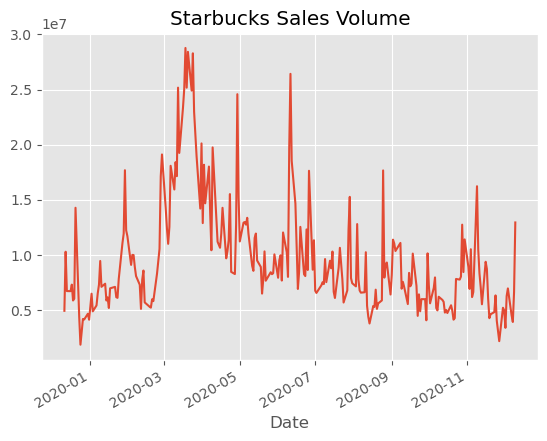

In [121]:
df['Volume'].plot(title='Starbucks Sales Volume')

In [122]:
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6]

In [123]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [124]:
# X_train = X_ss[:200, :]
# X_test = X_ss[200:, :]

# y_train = y_mm[:200, :]
# y_test = y_mm[200:, :] 

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size = .2, shuffle = False)


In [126]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 


Training Shape (202, 5) (202, 1)
Testing Shape (51, 5) (51, 1)


In [127]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [128]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [129]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([202, 1, 5]) torch.Size([202, 1])
Testing Shape torch.Size([51, 1, 5]) torch.Size([51, 1])


### Build Pytorch LSTM Model

In [130]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [144]:
## Pytorch Model Params

num_epochs = 1000 #1000 epochs
learning_rate = 0.01 #0.001 lr

input_size = 5 #number of features
hidden_size = 1 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes 

In [138]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])

In [139]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [145]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.01638
Epoch: 100, loss: 0.01109
Epoch: 200, loss: 0.01073
Epoch: 300, loss: 0.01071
Epoch: 400, loss: 0.01065
Epoch: 500, loss: 0.01061
Epoch: 600, loss: 0.01059
Epoch: 700, loss: 0.01060
Epoch: 800, loss: 0.01051
Epoch: 900, loss: 0.01061


In [146]:
df_X_ss = ss.transform(df.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

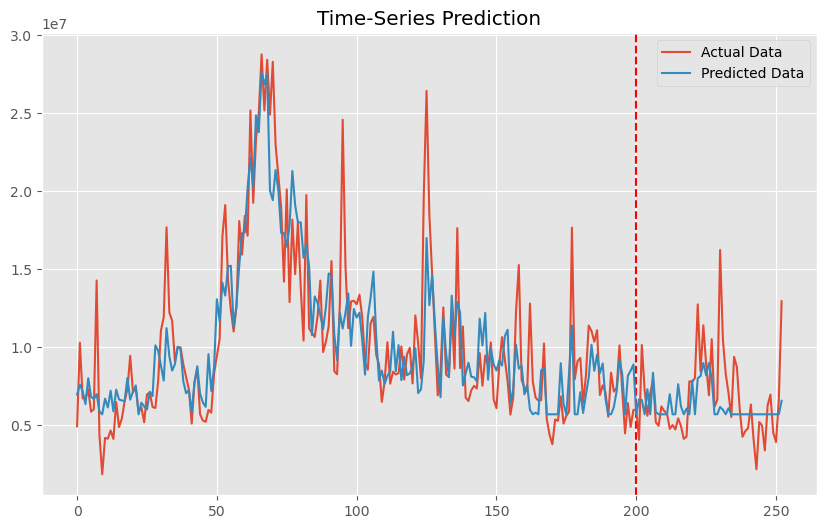

In [147]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

### Test our LSTM Model on Starbucks Data

In [101]:
from sklearn.model_selection import train_test_split

In [102]:
df = pd.read_csv('SBUX.csv', index_col='Date', parse_dates=True)
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6]
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = pd.DataFrame(ss.fit_transform(X))
y_mm = pd.DataFrame(mm.fit_transform(y)) 
X_train_sb, X_test_sb, y_train_sb, y_test_sb = train_test_split(X_ss, y_mm, test_size = .2, shuffle = False)
# X_train = X_ss[:200, :]
# X_test = X_ss[200:, :]

# y_train = y_mm[:200, :]
# y_test = y_mm[200:, :] 

In [107]:
dl_train, ds_train = lstm_timeseries_feat_and_targ(X_train_sb, y_train_sb, day_feat, day_targ,exclude=None)
dl_test, ds_test = lstm_timeseries_feat_and_targ(X_test, T_test, day_feat, day_targ, exclude=None)

In [108]:
our_mdl = BasicLSTM(num_feat=5, num_hiddens=1, num_out=1, lr=0.01)

In [110]:
logger = TensorBoardLogger("lightning_logs", name="market")
trainer = pl.Trainer(max_epochs=10,logger=logger) # with default learning rate, 0.001 (this tiny learning rate makes learning slow)
trainer.fit(our_mdl, train_dataloaders=dl_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
30        Trainable params
0         Non-trainable params
30        Total params
0.000     Total estimated model params size (MB)


Epoch 9: 100%|█████████████████████████████████████████████████████████████| 201/201 [00:02<00:00, 90.60it/s, v_num=15]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█████████████████████████████████████████████████████████████| 201/201 [00:02<00:00, 89.83it/s, v_num=15]


In [111]:
trainer.test(our_mdl,dataloaders=dl_train)

The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 311.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.012397903345368054
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.012397903345368054}]